In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Paths
image_dir = "/kaggle/input/road-lane-segmentation-imgs-and-labels/dataset/train/images"  # Path to images
label_dir = "/kaggle/input/road-lane-segmentation-imgs-and-labels/dataset/train/labels"  # Path to label (.txt) files
output_dir = "/kaggle/working/new_output_masks"  # Where to save the masks
os.makedirs(output_dir, exist_ok=True)

# Define color for lane markings
LANE_COLOR = (255, 0, 0)  # Red for lane markings

# Image size (adjust as needed)
IMG_SIZE = (1280, 720)  # Adjust based on dataset

# Function to parse label file and generate a mask
def create_mask(label_path, image_size):
    mask = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)  # Black background

    with open(label_path, "r") as file:
        for line in file:
            values = list(map(float, line.strip().split()))
            class_id = int(values[0])  # First value is class ID (0 = lane)
            coords = np.array(values[1:]).reshape(-1, 2)  # Remaining are X, Y points

            coords[:, 0] *= image_size[0]  # Convert normalized X
            coords[:, 1] *= image_size[1]  # Convert normalized Y
            coords = coords.astype(np.int32)

            # Draw filled polygon on the mask
            cv2.fillPoly(mask, [coords], LANE_COLOR)

    return mask

# Process all label files
label_files = [f for f in os.listdir(label_dir) if f.endswith(".txt")]

for file in tqdm(label_files, desc="Processing Labels"):
    label_path = os.path.join(label_dir, file)
    mask = create_mask(label_path, IMG_SIZE)

    # Save mask with the same filename as the label file but as an image
    save_path = os.path.join(output_dir, file.replace(".txt", ".png"))
    cv2.imwrite(save_path, mask)

print(f"✅ All masks saved in: {output_dir}")


Processing Labels: 100%|██████████| 815/815 [00:10<00:00, 77.30it/s]

✅ All masks saved in: /kaggle/working/new_output_masks


Loading Data: 100%|██████████| 815/815 [00:18<00:00, 44.59it/s]


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 677ms/step - accuracy: 0.8424 - loss: 0.4692 - val_accuracy: 0.8488 - val_loss: 0.3324
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.8519 - loss: 0.3278 - val_accuracy: 0.8735 - val_loss: 0.3044
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.8651 - loss: 0.3013 - val_accuracy: 0.8645 - val_loss: 0.2811
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.8815 - loss: 0.2749 - val_accuracy: 0.8768 - val_loss: 0.2622
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.8853 - loss: 0.2598 - val_accuracy: 0.8870 - val_loss: 0.2639
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.8893 - loss: 0.2633 - val_accuracy: 0.8765 - val_loss: 0.2756
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8943 - loss: 0.2523 - val_accuracy: 0.8905 - val_loss: 0.2473
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.8981 - loss: 0.2399 - val_accuracy: 0

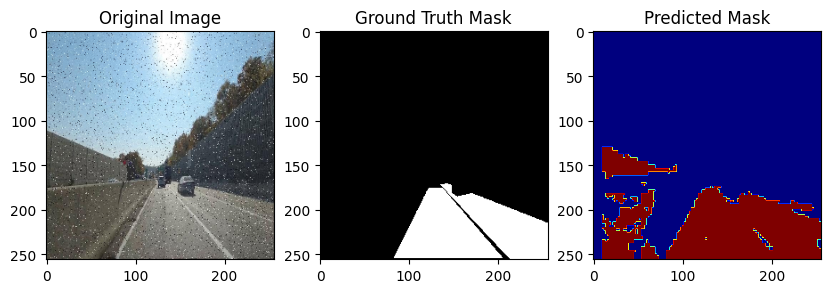

In [8]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set Paths
image_dir = "/kaggle/input/road-lane-segmentation-imgs-and-labels/dataset/train/images"  # Path to original images
mask_dir = "/kaggle/working/new_output_masks"  # Path to color-coded masks

# Define image size and classes
IMG_SIZE = 256
NUM_CLASSES = 2  # Background + Lane

# Function to load images and masks
def load_data(image_dir, mask_dir):
    images, masks = [], []
    file_list = sorted(os.listdir(image_dir))  # Ensure order consistency
    
    for file in tqdm(file_list, desc="Loading Data"):
        img_path = os.path.join(image_dir, file)
        mask_path = os.path.join(mask_dir, file.replace(".jpg", ".png"))  # Adjust if different

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0  # Normalize
        
        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        
        # Convert color-coded mask to class labels (Assuming 255 = lane, 0 = background)
        mask = np.where(mask > 0, 1, 0)  # Convert to binary class mask
        
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load dataset
X, Y = load_data(image_dir, mask_dir)
Y = np.expand_dims(Y, axis=-1)  # Add channel dimension for compatibility

# Split dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define U-Net Model
def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)

    # Decoder
    u1 = layers.UpSampling2D((2,2))(c3)
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D((2,2))(c4)
    outputs = layers.Conv2D(num_classes, (1,1), activation='softmax')(u2)  # Softmax for segmentation

    return models.Model(inputs, outputs)

# Compile and train U-Net
unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
unet_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=16)

# Function to visualize results
def visualize_sample(idx):
    plt.figure(figsize=(10,5))

    # Original image
    plt.subplot(1,3,1)
    plt.imshow(X[idx])
    plt.title("Original Image")

    # Ground truth mask
    plt.subplot(1,3,2)
    plt.imshow(Y[idx].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")

    # Model Prediction
    pred_mask = unet_model.predict(X[idx:idx+1])
    pred_mask = np.argmax(pred_mask, axis=-1).squeeze()

    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap='jet')
    plt.title("Predicted Mask")
    plt.show()

# Test the model on a sample image
visualize_sample(0)


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensure Y_pred has the correct shape
def iou_metric(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=-1)  # Convert softmax output to class labels
    y_true = y_true.squeeze()  # Remove unnecessary dimensions

    # Ensure both masks have the same shape
    if y_true.shape != y_pred.shape:
        y_pred = np.expand_dims(y_pred, axis=-1)  # Expand dimensions if missing

    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    return np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0

# Dice Coefficient
def dice_coefficient(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=-1)  # Convert softmax output to class labels
    y_true = y_true.squeeze()  # Ensure same shape

    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0

# Function to evaluate the model
def evaluate_model(model, X_val, Y_val):
    print("Evaluating model...")

    # Get predictions
    Y_pred = model.predict(X_val)
    Y_pred = np.argmax(Y_pred, axis=-1)  # Convert softmax to class labels
    Y_pred = np.expand_dims(Y_pred, axis=-1)  # Ensure correct shape

    Y_true = Y_val.squeeze()  # Ensure same shape

    # Compute metrics
    acc = accuracy_score(Y_true.flatten(), Y_pred.flatten())  # Pixel-wise accuracy
    iou = iou_metric(Y_true, Y_pred)
    dice = dice_coefficient(Y_true, Y_pred)

    # Print results
    print(f"Pixel Accuracy: {acc:.4f}")
    print(f"IoU Score: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(Y_true.flatten(), Y_pred.flatten())
    print("\nConfusion Matrix:\n", cm)

    # Classification report
    print("\nClassification Report:\n", classification_report(Y_true.flatten(), Y_pred.flatten()))

# Run evaluation
evaluate_model(unet_model, X_val, Y_val)


Evaluating model...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Pixel Accuracy: 0.9222
IoU Score: 0.0000
Dice Coefficient: 0.0000

Confusion Matrix:
 [[8832087  200919]
 [ 629965 1019397]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96   9033006
           1       0.84      0.62      0.71   1649362

    accuracy                           0.92  10682368
   macro avg       0.88      0.80      0.83  10682368
weighted avg       0.92      0.92      0.92  10682368

